<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/Tatyana-Nekrasova-folder/Tatyana%20Nekrasova/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F%20%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0%20%D0%9D%D0%B5%D0%BA%D1%80%D0%B0%D1%81%D0%BE%D0%B2%D0%B0%20%D0%9F%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation, Input, concatenate
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L2
from sklearn.model_selection import train_test_split

In [ ]:
data.shape # кол-во строк и столбцов

(1982, 4587)

## Работа с таблицей

In [ ]:
# удалить столбцы, в которых нет ни одного значения
data.dropna(axis=1, how='all', inplace=True)
print(data.shape)


(1982, 3703)


In [ ]:
# удалить строки с пустыми значениями в столбце ЗаключениеМК
data.dropna(subset=['ЗаключениеМК'], inplace=True)
print(data.shape)


(1575, 3703)


In [ ]:
# удалить ошибочные данные
data = data.drop(data[data['ЗаключениеМК'] == 'машинист бульдозера'].index)
data = data.drop(data[data['ЗаключениеМК'] == 'Газоспасатель'].index)
data = data.drop(data[data['ЗаключениеМК'] == ' Газоспасатель'].index)

In [ ]:
# просмотр значений в целевой колонке
data['ЗаключениеМК'].value_counts()

Годен                               1434
ГоденСКоррекциейЗрения               123
ВременноНегоден                        9
НуждаетсяВДообследованииИЛечении       2
ОграниченноГоден                       2
ГоденБезРаботНаВысотах                 1
Name: ЗаключениеМК, dtype: int64

In [ ]:
# перенос в новый датасет колонок, котрые на мой взгляд будут влиять на результат
import re

data_1 = data.filter(regex=re.compile(r'ГоденНегоден_ЗначениеПредставление|ВредныеФакторы|ЗаключениеМК|Профессия|Психосвидетельствование|МКБ'))
print(data_1.shape)

(1571, 127)


In [ ]:
# Замена NAN на 0 соответствующего типа
for i in data_1.columns.values.tolist():
    if data_1[i].dtypes==object:
       data_1[i]= data_1[i].fillna('0')
    elif data_1[i].dtypes==int or  data_1[i].dtypes==float:
       data_1[i]= data_1[i].fillna(0)

In [ ]:
# преобразование значений в целевой колонке к трем классам
data_1['ЗаключениеМК'] = data_1['ЗаключениеМК'].map({'Годен': 'Годен', 'ГоденСКоррекциейЗрения': 'ОграниченноГоден', 'ВременноНегоден': 'ОграниченноГоден', 'НуждаетсяВДообследованииИЛечении': 'ОграниченноГоден', 'ОграниченноГоден': 'ОграниченноГоден', 'ГоденБезРаботНаВысотах': 'ОграниченноГоден'})
data_1['ЗаключениеМК'].value_counts()

<ipython-input-11-b70b2ebabfa1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['ЗаключениеМК'] = data_1['ЗаключениеМК'].map({'Годен': 'Годен', 'ГоденСКоррекциейЗрения': 'ОграниченноГоден', 'ВременноНегоден': 'ОграниченноГоден', 'НуждаетсяВДообследованииИЛечении': 'ОграниченноГоден', 'ОграниченноГоден': 'ОграниченноГоден', 'ГоденБезРаботНаВысотах': 'ОграниченноГоден'})


Годен               1434
ОграниченноГоден     137
Name: ЗаключениеМК, dtype: int64

In [ ]:
# удаление дублирующей колонки и колонки с значением nan (они нашлись придальнейшей обработке таблицы)
data_1 = data_1.drop('ЗаключениеМКПредставление',  axis=1)
data_1 = data_1.drop('Хирургия3_МКБ101', axis=1)
data_1 = data_1.drop('Хирургия3_ГоденНегоден_ЗначениеПредставление', axis=1)

## Преобразование данных

In [ ]:
# преобразование данных в числовые
import numpy as np


In [ ]:
# подготовка колонок для перевода категориальных данных в OHE
data_2 = data_1.copy()
data_2.drop(['Профессия', 'ЗаключениеМК', 'ВредныеФакторы'], axis=1, inplace=True)
data_2

,ПсихиатрияНаркология1_МКБ101,ПсихиатрияНаркология1_ГоденНегоден_ЗначениеПредставление,Офтальмология1_МКБ101,Офтальмология1_ГоденНегоден_ЗначениеПредставление,Оториноларингология1_МКБ101,Оториноларингология1_ГоденНегоден_ЗначениеПредставление,ХирургНеИсп1_МКБ101,ХирургНеИсп1_ГоденНегоден_ЗначениеПредставление,Гинекология1_МКБ101,Гинекология1_ГоденНегоден_ЗначениеПредставление,...,Рентгенология1_МКБ102,Рентгенология2_МКБ102,Психиатрия3_МКБ101,Психиатрия3_МКБ102,Психиатрия3_ГоденНегоден_ЗначениеПредставление,Психиатрия4_МКБ101,Психиатрия4_МКБ102,Психиатрия4_ГоденНегоден_ЗначениеПредставление,Оториноларингология3_МКБ101,Оториноларингология3_ГоденНегоден_ЗначениеПредставление
0,Z00.0,Годен,Z00.0,Годен,Z00.0,Годен,Z00.0,Годен,Z00.0,Годен,...,0,0,0,0,0,0,0,0,0,0
1,Z00.0,Годен,Z00.0,Годен,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Z00.0,Годен,H52.1,Годен,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,Z00.0,Годен,Z00.0,Годен,Z00.0,Годен,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,H52.2,Годен,Z00.0,Годен,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961,Z00.0,Годен,Z00.0,Годен,Z00.0,Годен,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1962,Z00.0,Годен,0,0,Z00.0,Годен,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1972,Z00.0,Годен,Z00.0,Годен,Z00.0,Годен,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1973,Z00.0,Годен,Z00.0,Годен,Z00.0,Годен,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Преобразование в OHE
data_2 = pd.get_dummies(data_2)
data_2

,ПсихиатрияНаркология1_МКБ101_0,ПсихиатрияНаркология1_МКБ101_F06.6,ПсихиатрияНаркология1_МКБ101_F06.7,ПсихиатрияНаркология1_МКБ101_F07.0,ПсихиатрияНаркология1_МКБ101_F41.0,ПсихиатрияНаркология1_МКБ101_F98.5,ПсихиатрияНаркология1_МКБ101_R25.1,ПсихиатрияНаркология1_МКБ101_Z00.0,ПсихиатрияНаркология1_ГоденНегоден_ЗначениеПредставление_0,ПсихиатрияНаркология1_ГоденНегоден_ЗначениеПредставление_Годен,...,Психиатрия4_МКБ101_0,Психиатрия4_МКБ101_Z00.0,Психиатрия4_МКБ102_0,Психиатрия4_МКБ102_Z00.0,Психиатрия4_ГоденНегоден_ЗначениеПредставление_0,Психиатрия4_ГоденНегоден_ЗначениеПредставление_Годен,Оториноларингология3_МКБ101_0,Оториноларингология3_МКБ101_Z00.0,Оториноларингология3_ГоденНегоден_ЗначениеПредставление_0,Оториноларингология3_ГоденНегоден_ЗначениеПредставление_Годен
0,0,0,0,0,0,0,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
1,0,0,0,0,0,0,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
2,0,0,0,0,0,0,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
3,1,0,0,0,0,0,0,0,1,0,...,1,0,1,0,1,0,1,0,1,0
4,1,0,0,0,0,0,0,0,1,0,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961,0,0,0,0,0,0,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
1962,0,0,0,0,0,0,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
1972,0,0,0,0,0,0,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0
1973,0,0,0,0,0,0,0,1,0,1,...,1,0,1,0,1,0,1,0,1,0


In [ ]:
#Формирование таблицы с нужными стобцами для перобразования в OHE
data_3 = data_1[['ВредныеФакторы']]
data_3

,ВредныеФакторы
0,11.4
1,4.2.5
2,4.2.5
3,11.1
4,11.1
...,...
1961,"4.4,4.5,6.1"
1962,4.4
1972,3.1.8.2
1973,"4.2.5,6.1"


In [ ]:
# Разбиваем строки на списки значений и объединяем их в один список
all_values = []
for value_list in data_3['ВредныеФакторы'].str.split(','):
    all_values.extend(value_list)

# Создаем новые столбцы с one-hot encoding
for unique_value in set(all_values):
    data_3[f'one_hot_{unique_value}'] = data_3['ВредныеФакторы'].str.contains(unique_value).astype(int)

# Удаляем исходный столбец
data_3.drop(columns=['ВредныеФакторы'], inplace=True)


In [ ]:
data_3


,one_hot_4.2.4,one_hot_15,one_hot_1.3,one_hot_4.7,one_hot_4.1,one_hot_13,one_hot_1.8.2,one_hot_1.8.2.1,one_hot_1.39,one_hot_1.2,...,one_hot_4.2,one_hot_25,one_hot_1.49.14,one_hot_3.1.2,one_hot_3.1.7,one_hot_4.2.3,one_hot_1.24,one_hot_11.2,one_hot_1.8.3.2,one_hot_1.49.2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1961,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1962,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1972,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1973,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# обьединение двух таблиц в формате OHE
data_ohe = pd.concat([data_3, data_2], axis=1)

In [ ]:
data_ohe = data_ohe.astype(float)
xTrain01 = data_ohe.to_numpy()
xTrain01.shape

(1571, 518)

Создание y_train

In [ ]:
#Формирование таблицы с нужными стобцами
data_4 = data_1[['ЗаключениеМК']]
data_4

,ЗаключениеМК
0,Годен
1,Годен
2,ОграниченноГоден
3,Годен
4,ОграниченноГоден
...,...
1961,Годен
1962,Годен
1972,Годен
1973,Годен


In [ ]:
yTrain =  pd.get_dummies(data_4)
yTrain = yTrain.astype(float)
yTrain = yTrain.to_numpy()

In [ ]:
yTrain

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [ ]:
yTrain.shape

(1571, 2)

In [ ]:
# подсчет количества значений в каждом классе
# Если yTrain представлен в виде one-hot encoding:
class_counts = np.sum(yTrain, axis=0)

# Если yTrain представлен в виде индексов классов:
# class_counts = np.bincount(yTrain)

for i, count in enumerate(class_counts):
    print(f'Класс {i}: {count} значений')


Класс 0: 1434.0 значений
Класс 1: 137.0 значений


Обработка текстовых данных

In [ ]:
#Формирование таблицы с нужными стобцами
data_5 = data_1[['Профессия']]
data_5

,Профессия
0,Ведущий специалист по организации обуения
1,Ведущий специалист
2,Главный менеджер
3,Главный специалист
4,Старший специалист
...,...
1961,Инженер
1962,Начальник лаборатории
1972,"Инженер по бурению 1 категории, непосредственн..."
1973,Приемщик вагонов в депо


In [ ]:
#sklearn.utils.resample
from gensim.models import Word2Vec

# Разбиваем строки на списки слов
data_5['split_profession'] = data_5['Профессия'].str.split()

# Обучаем Word2Vec модель на полученных словах
model = Word2Vec(data_5['split_profession'], min_count=1, vector_size=100, window=5)

def get_sentence_vector(sentence, model):
    words = sentence.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if not word_vectors:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

data_5['vector_profession'] = data_5['Профессия'].apply(lambda x: get_sentence_vector(x, model))


In [ ]:
data_5

,Профессия,split_profession,vector_profession
0,Ведущий специалист по организации обуения,"[Ведущий, специалист, по, организации, обуения]","[-0.004978101, 0.0049648588, 0.0017282281, 0.0..."
1,Ведущий специалист,"[Ведущий, специалист]","[-0.008589536, 0.0070572044, 0.0024156922, 0.0..."
2,Главный менеджер,"[Главный, менеджер]","[-0.0032041178, -0.0001310918, 0.0017961467, 0..."
3,Главный специалист,"[Главный, специалист]","[-0.007957045, 0.007144956, 0.00091820356, 0.0..."
4,Старший специалист,"[Старший, специалист]","[-0.008948991, 0.009582704, 0.0018989069, 0.00..."
...,...,...,...
1961,Инженер,[Инженер],"[-0.008135378, 0.0035013666, -0.0005830897, -0..."
1962,Начальник лаборатории,"[Начальник, лаборатории]","[0.0011305714, 0.00029124087, 0.003039887, -0...."
1972,"Инженер по бурению 1 категории, непосредственн...","[Инженер, по, бурению, 1, категории,, непосред...","[-0.0021240085, 0.0007464626, 0.001148368, -0...."
1973,Приемщик вагонов в депо,"[Приемщик, вагонов, в, депо]","[0.0028270092, -0.00015133704, 0.0031504063, 0..."


In [ ]:
# Преобразуем столбец 'vector_profession' в NumPy массив и сохраняем его в переменную x_train
xTrain02 = np.vstack(data_5['vector_profession'].values)

In [ ]:
xTrain02.shape

(1571, 100)

## Обучение

In [ ]:
# Разделение данных на обучающие, валидационные и тестовые выборки
x_train_1, x_val_test_1, x_train_2, x_val_test_2, y_train, y_val_test = train_test_split(
    xTrain01, xTrain02, yTrain, test_size=0.4, random_state=42)

x_val_1, x_test_1, x_val_2, x_test_2, y_val, y_test = train_test_split(
    x_val_test_1, x_val_test_2, y_val_test, test_size=0.5, random_state=42)

In [ ]:
# Проверка количества значений в каждом классе в каждой выборке, 
# где класс 0 - годен, класс 1 -  ограниченно годен
F = [y_train, y_val, y_test]
for f in F:
  class_counts = np.sum(f, axis=0)
  print([name for name in globals() if globals()[name] is f][0])
  for i, count in enumerate(class_counts):
    print(f'Класс {i}: {count} значений')

y_train
Класс 0: 864.0 значений
Класс 1: 78.0 значений
y_val
Класс 0: 287.0 значений
Класс 1: 27.0 значений
y_test
Класс 0: 283.0 значений
Класс 1: 32.0 значений


In [ ]:
input1 = Input((x_train_1.shape[1],))
input2 = Input((x_train_2.shape[1],))


x1 = input1                               # Ветка 1
x1 = Dense(128, activation="relu", kernel_regularizer=L2(0.01))(x1)
x1 = Dense(1000, activation="tanh")(x1)
x1 = Dense(100, activation="relu")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(20, activation="relu", kernel_regularizer=L2(0.01))(x2)
x2 = Dense(500, activation="relu")(x2)
x2 = Dropout(0.3)(x2)

x = concatenate([x1, x2])             # Объединение двух веток

x = Dense(15, activation='relu', kernel_regularizer=L2(0.01))(x2)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)      

# В Model передаются входы и выход
model_1 = Model((input1, input2), x)


In [ ]:
# Компиляция модели
model_1.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
history_1 = model_1.fit([x_train_1, x_train_2], y_train, validation_data=([x_val_1, x_val_2], y_val),
                    epochs=10, batch_size=32)


Epoch 1/10
30/30 [==============================] - 6s 14ms/step - loss: 1.3094 - accuracy: 0.8344 - val_loss: 1.3061 - val_accuracy: 0.9140
Epoch 2/10
30/30 [==============================] - 0s 6ms/step - loss: 1.3028 - accuracy: 0.9140 - val_loss: 1.2993 - val_accuracy: 0.9140
Epoch 3/10
30/30 [==============================] - 0s 6ms/step - loss: 1.2963 - accuracy: 0.9151 - val_loss: 1.2925 - val_accuracy: 0.9140
Epoch 4/10
30/30 [==============================] - 0s 6ms/step - loss: 1.2892 - accuracy: 0.9172 - val_loss: 1.2856 - val_accuracy: 0.9140
Epoch 5/10
30/30 [==============================] - 0s 6ms/step - loss: 1.2824 - accuracy: 0.9172 - val_loss: 1.2786 - val_accuracy: 0.9140
Epoch 6/10
30/30 [==============================] - 0s 6ms/step - loss: 1.2755 - accuracy: 0.9172 - val_loss: 1.2717 - val_accuracy: 0.9140
Epoch 7/10
30/30 [==============================] - 0s 6ms/step - loss: 1.2685 - accuracy: 0.9172 - val_loss: 1.2649 - val_accuracy: 0.9140
Epoch 8/10
30/30 [=

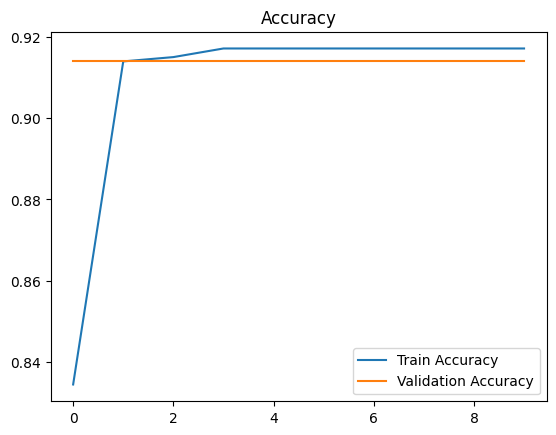

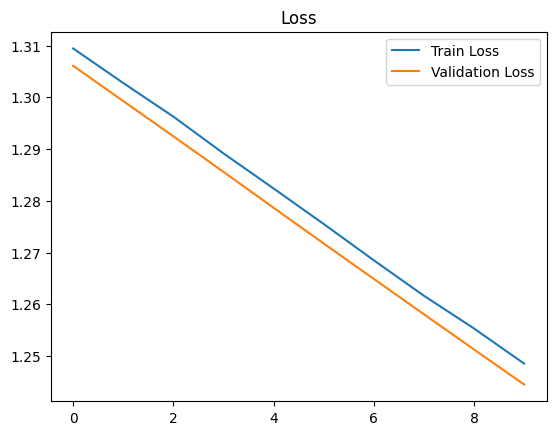

In [ ]:
# Графики метрик
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history_1.history['loss'], label='Train Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
# Оценка модели
test_loss, test_accuracy = model_1.evaluate([x_test_1, x_test_2], y_test)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

10/10 [==============================] - 0s 3ms/step - loss: 1.2459 - accuracy: 0.8984
Test loss: 1.2459, Test accuracy: 0.8984


### Балансировка

In [ ]:
from sklearn.utils import resample

# Конвертируем one-hot encoding в индексы классов
yTrain_class_indices = np.argmax(yTrain, axis=1)

# Создаем датафреймы с xTrain01 и xTrain02
data01 = pd.DataFrame(xTrain01, columns=[f'feature_1_{i}' for i in range(xTrain01.shape[1])])
data02 = pd.DataFrame(xTrain02, columns=[f'feature_2_{i}' for i in range(xTrain02.shape[1])])

# Объединяем датафреймы и добавляем столбец с индексами классов
data_ = pd.concat([data01, data02], axis=1)
data_['target'] = yTrain_class_indices

data_

,feature_1_0,feature_1_1,feature_1_2,feature_1_3,feature_1_4,feature_1_5,feature_1_6,feature_1_7,feature_1_8,feature_1_9,...,feature_2_91,feature_2_92,feature_2_93,feature_2_94,feature_2_95,feature_2_96,feature_2_97,feature_2_98,feature_2_99,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000332,0.003023,-0.004313,0.008257,0.005496,-0.001054,-0.006514,0.000471,0.000889,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.000884,0.001200,-0.004922,0.004319,0.001762,0.005912,-0.005798,-0.005199,-0.001041,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004051,-0.005251,-0.004443,-0.006343,0.002526,0.002463,0.008373,-0.000587,0.003122,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001488,-0.002912,-0.005418,0.002679,0.003655,0.006437,0.000389,0.002889,0.000312,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000395,0.001406,-0.001806,0.010373,0.004309,0.004319,-0.000779,0.002321,-0.005923,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1566,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.009806,-0.007284,-0.001386,0.012307,0.006934,-0.001937,-0.010438,0.004611,-0.007949,0
1567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000789,-0.001041,0.005171,-0.002615,0.005008,0.008999,-0.006326,0.003835,-0.009612,0
1568,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.001351,-0.001576,-0.000542,0.003397,0.005953,-0.000508,-0.003010,0.000876,-0.001510,0
1569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.003308,-0.001413,0.002487,0.003559,-0.000114,0.005903,-0.000101,0.001890,-0.002877,0


In [ ]:
# Разделяем датафрейм на отдельные классы
class_0 = data_[data_['target'] == 0]
class_1 = data_[data_['target'] == 1]
# class_2 = data_[data_['target'] == 2]

# Вычисляем количество примеров для каждого класса после балансировки
n_samples = max(len(class_0), len(class_1))

# Применяем upsampling или downsampling для каждого класса
class_0_resampled = resample(class_0, replace=True, n_samples=n_samples, random_state=42)
class_1_resampled = resample(class_1, replace=True, n_samples=n_samples, random_state=42)
# class_2_resampled = resample(class_2, replace=True, n_samples=n_samples, random_state=42)

# Объединяем сбалансированные классы в новый датафрейм
data_balanced = pd.concat([class_0_resampled, class_1_resampled])

# Выделяем сбалансированные данные для обучения
x_train_balanced_1 = data_balanced[[f'feature_1_{i}' for i in range(xTrain01.shape[1])]].values
x_train_balanced_2 = data_balanced[[f'feature_2_{i}' for i in range(xTrain02.shape[1])]].values
y_train_balanced_class_indices = data_balanced['target'].values

# Конвертируем индексы классов обратно в one-hot encoding
y_train_balanced = np.eye(2)[y_train_balanced_class_indices]

In [ ]:
x_train_balanced_1

array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
x_train_balanced_2

array([[ 1.1500726e-03,  1.1078559e-03, -2.7510466e-03, ...,
        -2.3994907e-03,  4.3320875e-03, -7.5887875e-03],
       [-2.7840249e-03, -9.6923881e-04, -1.5571597e-05, ...,
        -2.8970379e-03,  2.7431361e-03,  3.2759847e-03],
       [ 6.3097273e-04,  1.2578414e-03,  1.0502875e-03, ...,
        -9.7518461e-04,  8.3596604e-03, -1.7298585e-03],
       ...,
       [-7.3124858e-04,  1.1939524e-04,  6.1802380e-03, ...,
         1.0548475e-03, -1.1551994e-03,  6.1749388e-04],
       [-2.2680368e-03,  1.9345091e-03,  7.8574633e-03, ...,
        -6.0842778e-03,  6.2475698e-03, -4.5025521e-03],
       [-3.9390055e-03,  8.2325609e-03,  7.1334830e-03, ...,
         7.3592956e-03,  7.8449817e-04, -1.4503397e-03]], dtype=float32)

In [ ]:
y_train_balanced

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

In [ ]:
print(x_train_balanced_1.shape)
print(x_train_balanced_2.shape)
print(y_train_balanced.shape)

(2868, 518)
(2868, 100)
(2868, 2)


In [ ]:
# Если yTrain представлен в виде one-hot encoding:
class_counts = np.sum(y_train_balanced, axis=0)

# Если yTrain представлен в виде индексов классов:
# class_counts = np.bincount(yTrain)

for i, count in enumerate(class_counts):
    print(f'Класс {i}: {count} значений')

Класс 0: 1434.0 значений
Класс 1: 1434.0 значений


In [ ]:
# Разделение данных на обучающие, валидационные и тестовые выборки
Xtrain_1, Xval_test_1, Xtrain_2, Xval_test_2, Ytrain, Yval_test = train_test_split(
    x_train_balanced_1, x_train_balanced_2, y_train_balanced, test_size=0.4, random_state=42)

Xval_1, Xtest_1, Xval_2, Xtest_2, Yval, Ytest = train_test_split(
    x_val_test_1, x_val_test_2, y_val_test, test_size=0.5, random_state=42)

In [ ]:
# Проверка количества значений в каждом классе в каждой выборке, 
# где класс 0 - годен, класс 1 -  ограниченно годен
F = [y_train, y_val, y_test]
for f in F:
  class_counts = np.sum(f, axis=0)
  print([name for name in globals() if globals()[name] is f][0])
  for i, count in enumerate(class_counts):
    print(f'Класс {i}: {count} значений')

y_train
Класс 0: 864.0 значений
Класс 1: 78.0 значений
y_val
Класс 0: 287.0 значений
Класс 1: 27.0 значений
y_test
Класс 0: 283.0 значений
Класс 1: 32.0 значений


In [ ]:
input1 = Input((x_train_1.shape[1],))
input2 = Input((x_train_2.shape[1],))


x1 = input1                               # Ветка 1
x1 = Dense(128, activation="relu", kernel_regularizer=L2(0.01))(x1)
x1 = Dense(1000, activation="tanh")(x1)
x1 = Dense(100, activation="relu")(x1)

x2 = input2                               # Ветка 2
x2 = Dense(20, activation="relu", kernel_regularizer=L2(0.01))(x2)
x2 = Dense(500, activation="relu")(x2)
x2 = Dropout(0.3)(x2)

x = concatenate([x1, x2])             # Объединение двух веток

x = Dense(15, activation='relu', kernel_regularizer=L2(0.01))(x2)       # Промежуточный слой
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax')(x)      

# В Model передаются входы и выход
model_2 = Model((input1, input2), x)


In [ ]:
# Компиляция модели
model_2.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
history_2 = model_2.fit([Xtrain_1, Xtrain_2], Ytrain, validation_data=([Xval_1, Xval_2], Yval),
                    epochs=10, batch_size=32)

Epoch 1/10
54/54 [==============================] - 2s 8ms/step - loss: 1.3255 - accuracy: 0.4913 - val_loss: 1.3228 - val_accuracy: 0.1401
Epoch 2/10
54/54 [==============================] - 0s 5ms/step - loss: 1.3186 - accuracy: 0.5151 - val_loss: 1.3164 - val_accuracy: 0.1178
Epoch 3/10
54/54 [==============================] - 0s 5ms/step - loss: 1.3120 - accuracy: 0.5099 - val_loss: 1.3098 - val_accuracy: 0.1210
Epoch 4/10
54/54 [==============================] - 0s 5ms/step - loss: 1.3052 - accuracy: 0.5186 - val_loss: 1.3042 - val_accuracy: 0.0860
Epoch 5/10
54/54 [==============================] - 0s 5ms/step - loss: 1.2988 - accuracy: 0.5291 - val_loss: 1.2980 - val_accuracy: 0.0860
Epoch 6/10
54/54 [==============================] - 0s 6ms/step - loss: 1.2922 - accuracy: 0.5169 - val_loss: 1.2921 - val_accuracy: 0.0860
Epoch 7/10
54/54 [==============================] - 0s 5ms/step - loss: 1.2858 - accuracy: 0.5169 - val_loss: 1.2861 - val_accuracy: 0.0860
Epoch 8/10
54/54 [==

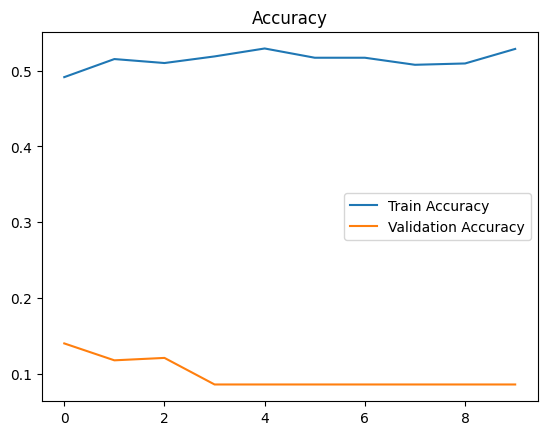

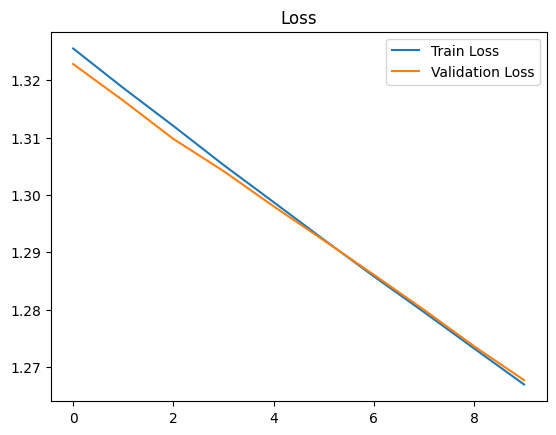

In [ ]:
# Графики метрик
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

plt.plot(history_2.history['loss'], label='Train Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

In [ ]:
# Оценка модели 
test_loss, test_accuracy = model_2.evaluate([Xtest_1, Xtest_2], Ytest)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

10/10 [==============================] - 0s 3ms/step - loss: 1.2676 - accuracy: 0.1016
Test loss: 1.2676, Test accuracy: 0.1016


## Выводы
Проведена работа по преобразованию данных к виду OHE, проведено обучение модели, основанной на Dense слоях. Обучение в первую эпоху длилось 6 сек, последующие по 0 сек. Первоначально я подумала, что сеть не обучается, но  значение loss от эпохи к эпохе уменьшается, видимо, не достаточно сильно, чтобы увеличивалась точность. Проконсультировалась с куратором курса, он подтвердил, что обучение идет, возможно это связано с небольшим размером данных. Оценка на тестовых данных равна 0,8984, соответсвенно дальнейшая работа будет направлена на повышение показателя точности.

Затем провела балансировку данных, но результат получила слишком низкий, на тестовых данных - 0,1016. Видимо, увеличение датасета данными такого вида не является положительным решением для нашего датасета.